In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, GlobalMaxPooling2D, Reshape
from tensorflow.keras.optimizers import Adam
from keras.applications import ConvNeXtXLarge
from tensorflow.keras.metrics import BinaryAccuracy, Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import uuid
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pos_path = os.path.join("/kaggle/input/snn-facial-recognition/data/anchor")
neg_path = os.path.join("/kaggle/input/snn-facial-recognition/data/negative")
anch_path = os.path.join("/kaggle/input/snn-facial-recognition/data/positive")

In [ ]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img,max_delta=0.02,seed =(1,2))
        img = tf.image.stateless_random_contrast(img,lower=0.6,upper=1,seed =(1,3))
        img = tf.image.stateless_random_flip_left_right(img,seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img,min_jpeg_quality=90,max_jpeg_quality=100,seed =(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img,lower=0.9,upper =1, seed=(np.random.randint(100),np.random.randint(100)))
        
        data.append(img)
        
    return data

In [ ]:
for file_name in os.listdir(os.path.join(pos_path)):
    img_path = os.path.join(pos_path, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [3]:
anchor_files = tf.data.Dataset.list_files(os.path.join(anch_path, "*.jpg"))
positive_files = tf.data.Dataset.list_files(os.path.join(pos_path, "*.jpg"))
negative_files = tf.data.Dataset.list_files(os.path.join(neg_path, "*.jpg"))

In [4]:
anchor = anchor_files.take(1998)
positive = positive_files.take(2000)
negative = negative_files.take(2000)

In [5]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'/kaggle/input/snn-facial-recognition/data/positive/c9c58123-e9a2-11ed-9f97-b48c9d5c815a.jpg'

In [6]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(224,224))
    img = img / 255.0
    return img

In [ ]:
img = preprocess('data/anchor/0005888c-e01e-11ed-92f1-e8fb1c5045c0.jpg')
img.numpy().max()

In [ ]:
plt.imshow(img)

In [7]:
# (Anchor, Positive) ---> 1,1,1,1,1
# (Anchor, Negative) ---> 0,0,0,0,0


positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:
samples = data.as_numpy_iterator()

In [9]:
exampple = samples.next()
exampple

(b'/kaggle/input/snn-facial-recognition/data/positive/8f4c0285-e9a2-11ed-9608-b48c9d5c815a.jpg',
 b'/kaggle/input/snn-facial-recognition/data/anchor/47423997-e01e-11ed-9519-e8fb1c5045c0.jpg',
 1.0)

In [10]:
# Preprocess function for twindata(ie. [Anch,positive], [Anchor,negative])
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img), label)

In [11]:
res = preprocess_twin(*exampple)

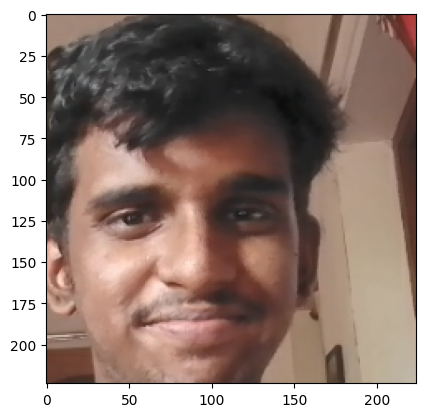

In [43]:
plt.imshow(res[1])

In [44]:
res[2]

1.0

In [12]:
# Build DataLoader Pipeline 

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [13]:
samples = data.as_numpy_iterator()

In [42]:
len(samples.next())

3

In [14]:
samp = samples.next()

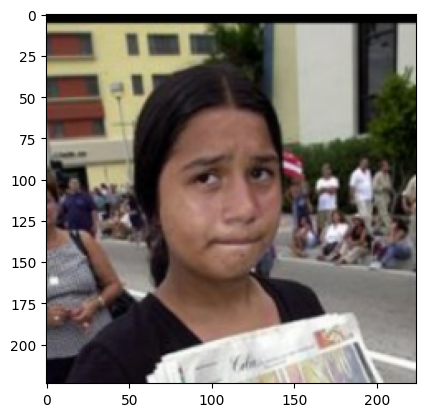

In [41]:
plt.imshow(samp[1])

In [15]:
# Training Partition 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(8)
train_data = train_data.prefetch(16)

In [26]:
# Testing Partition 
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(8)
test_data = test_data.prefetch(16)

In [16]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [17]:
def create_siamese_model():
    # Define the inputs
    input_shape = (224, 224, 3)
    input_image = Input(name="input_img", shape=input_shape)
    validation_image = Input(name="validation_img", shape=input_shape)

    # Define the base model
    base_model = ConvNeXtXLarge(
        include_top=False,
        weights='imagenet',
        pooling="max",
        input_shape=input_shape
    )
    
    # Get the output features from the base model
    x1 = base_model(input_image)
    x2 = base_model(validation_image)

    # Freeze the base model
    base_model.trainable = False
    
    # Apply mixed-precision casting to the output features
    x1 = tf.keras.layers.Activation('linear', dtype='float32')(x1)
    x2 = tf.keras.layers.Activation('linear', dtype='float32')(x2)

    # Compute the L1 distance between the output features from both inputs
    x = L1Dist()([x1, x2])

    # Add a dense layer with sigmoid activation to get the similarity score
    x = Dense(1, activation='sigmoid')(x)

    # Define the siamese model
    siamese_model = Model(inputs=[input_image, validation_image], outputs=x, name='Siamese_ConvNeXtXLarge')

    return siamese_model

In [18]:
# Create the siamese model using the input placeholders
siamese_model = create_siamese_model()

1393257616/1393257616 [==============================] - 7s 0us/step


In [19]:
siamese_model.summary()

Model: "Siamese_ConvNeXtXLarge"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_xlarge (Functional)   (None, 2048)         348147968   ['input_img[0][0]',              
                                                                  'validation

In [20]:
# Compile the model using binary cross-entropy loss and Adam optimizer with a learning rate of 0.001
siamese_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [21]:
@tf.function
def train_step(x1, x2, y, siamese_model, opt):
    with tf.GradientTape() as tape:
        y_pred = siamese_model([x1, x2])
        loss = tf.keras.losses.binary_crossentropy(y, y_pred[:,0], from_logits=False)
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    return loss

In [22]:
def data_generator(data):
    while True:
        for x1, x2, y in data:
            yield ([x1, x2], y)

In [23]:
def train_model(train_data, epochs, checkpoint_prefix=None):
    # Create an instance of the Siamese model
    siamese_model = create_siamese_model()
    
    # Compile the model using binary cross-entropy loss and Adam optimizer with a learning rate of 0.001
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    siamese_model.compile(loss='binary_crossentropy', optimizer=optimizer)

    # Define the checkpoint directory and prefix
    checkpoint_dir = "./training_checkpoints"
    if checkpoint_prefix is not None:
        checkpoint_prefix = os.path.join(checkpoint_dir, checkpoint_prefix)
    checkpoint = tf.train.Checkpoint(model=siamese_model, opt=optimizer)

    # Define the training steps per epoch
    steps_per_epoch = len(train_data)

    # Loop through epochs
    for epoch in range(1, epochs+1):
        print(f'\n {epoch}/{epochs}')
        progbar = tf.keras.utils.Progbar(steps_per_epoch)
        
        # Train the model on the generator
        history = siamese_model.fit(
            data_generator(train_data),
            steps_per_epoch=steps_per_epoch,
#             verbose=0
        )

        # Calculate the recall and precision for the epoch
        r = tf.keras.metrics.Recall()
        p = tf.keras.metrics.Precision()
        for x1, x2, y in train_data:
            y_pred = siamese_model([x1, x2])
            r.update_state(y, y_pred[:,0])
            p.update_state(y, y_pred[:,0])

        # Print the metrics for the epoch
        print(f"Loss: {history.history['loss'][-1]:.4f} - Recall: {r.result().numpy():.4f} - Precision: {p.result().numpy():.4f}")
        
        # Save checkpoints
        if checkpoint_prefix is not None and epoch % 10 == 0:
            checkpoint.save(f"{checkpoint_prefix}_epoch_{epoch}")

In [24]:
%%time
EPOCHS = 15
train_model(train_data, EPOCHS)


 1/15
350/350 [==============================] - 203s 478ms/step - loss: 0.4271
Loss: 0.4271 - Recall: 0.9248 - Precision: 0.9117

 2/15
350/350 [==============================] - 165s 470ms/step - loss: 0.2434
Loss: 0.2434 - Recall: 0.9564 - Precision: 0.9234

 3/15
350/350 [==============================] - 165s 470ms/step - loss: 0.1831
Loss: 0.1831 - Recall: 0.9710 - Precision: 0.9522

 4/15
350/350 [==============================] - 164s 470ms/step - loss: 0.1486
Loss: 0.1486 - Recall: 0.9856 - Precision: 0.9566

 5/15
350/350 [==============================] - 164s 469ms/step - loss: 0.1224
Loss: 0.1224 - Recall: 0.9913 - Precision: 0.9476

 6/15
350/350 [==============================] - 164s 470ms/step - loss: 0.1063
Loss: 0.1063 - Recall: 0.9837 - Precision: 0.9782

 7/15
350/350 [==============================] - 164s 470ms/step - loss: 0.0895
Loss: 0.0895 - Recall: 0.9921 - Precision: 0.9652

 8/15
350/350 [==============================] - 164s 469ms/step - loss: 0.0859
Lo

In [32]:
# Batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [33]:
# Make Predictions
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 0s 496ms/step


array([[0.7430446 ],
       [0.6275445 ],
       [0.7568399 ],
       [0.68293697],
       [0.82967687],
       [0.7250718 ],
       [0.77969   ],
       [0.6549873 ]], dtype=float32)

In [34]:
[1 if prediction >0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 1, 1, 1, 1]

In [35]:
y_true

array([0., 0., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [36]:
# Creating Metric object
m = Recall()
m.update_state(y_true,y_hat)

m.result().numpy()

1.0

In [37]:
m= Precision()

m.update_state(y_true,y_hat)
m.result().numpy()

0.625

In [38]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input,test_val])
    r.update_state(y_true,yhat)
    p.update_state(y_true,yhat)
    
print(r.result().numpy(),p.result().numpy())

1/1 [==============================] - 4s 4s/step
0.9982935 0.48872182


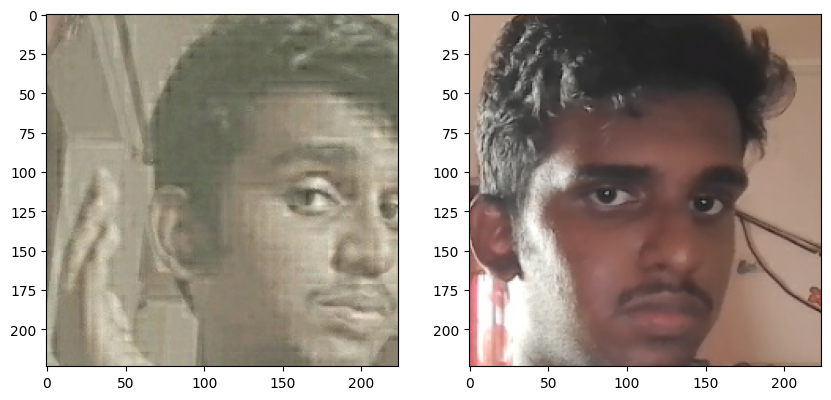

In [39]:
# Set Plot Size 
plt.figure(figsize=(10,8))

# Set first subplot 
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second Subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

plt.show()

In [28]:
# Save weights
siamese_model.save('convnext_xl_siamesemodel.h5')

In [29]:
from IPython.display import FileLink
FileLink(r'convnext_xl_siamesemodel.h5')

/kaggle/working/convnext_xl_siamesemodel.h5

In [40]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Calculate predictions
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

# Plot AUC-ROC curve
fpr, tpr, _ = roc_curve(y_true, y_hat)
roc_auc = auc(fpr, tpr)
fig_roc = go.Figure()
fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc))
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), showlegend=False))
fig_roc.update_layout(title='Receiver Operating Characteristic (ROC) Curve',
                      xaxis=dict(title='False Positive Rate'),
                      yaxis=dict(title='True Positive Rate'),
                      template='plotly_white')
fig_roc.show()

# Plot confusion matrix
y_pred = (y_hat > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
fig_cm = ff.create_annotated_heatmap(z=cm,
                                     x=['Predicted 0', 'Predicted 1'],
                                     y=['Actual 0', 'Actual 1'],
                                     colorscale='Viridis')
fig_cm.update_layout(title='Confusion Matrix',
                     xaxis=dict(title='Predicted Label'),
                     yaxis=dict(title='True Label'),
                     template='plotly_white')
fig_cm.show()

1/1 [==============================] - 0s 478ms/step
